In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.io import loadmat
from scipy.cluster import hierarchy
import matplotlib

In [2]:
MTsat, R1, MD, R2, MTV, R2s = 0, 1, 2, 3, 4, 5
ANALYSE_BY_AREAS = True
ANALYSE_BY_SCANS = False


In [3]:
def D_kl(p1, p2):
    """
    calculate D_kl between two matrixes
    :param p1 first matrix
    :param p2 second mstrix
    :return:
    """
    C1 = np.einsum('ij,ik->ijk', p1, 1 / p2)  ###is it the right way?
    C2 = np.log(C1)
    C2[p1 == 0, :] = 0
    return np.einsum('ij,ijk->jk', p1, C2)


def D_kl_vec(p_y_x_hat):
    """
    function to
    :param p_y_x_hat:
    :return:
    """
    Dkl_vals = []
    for idx in range(p_y_x_hat.shape[1]):
        p_mean = np.mean(p_y_x_hat, axis=1)
        p_cur = p_y_x_hat[:, idx]
        dkl = sum([p_cur[x] * np.log(p_cur[x] / p_mean[x]) if (p_cur[x] > 0) 
                   else 0 for x in range(p_y_x_hat.shape[0])])
        # dkl = -sum([p_mean[x]*np.log(p_cur[x]/p_mean[x]) if (p_mean[x] > 0 and p_cur[x] > 0) else 0 for x in range(33)])
        Dkl_vals.append(dkl)
    return Dkl_vals


def generate_beta(max_value = 10000, length = 800):
    """
    making vector of decreasing beta values.
    :param max_value: maximum beta value
    :param length: length of vector
    :return: vetor of beta's
    """
    beta_values = [max_value]
    for idx in range(length-1):
        beta_values.append(beta_values[-1]*0.99)
    return beta_values[::-1]


In [4]:
def load_data(path, contrast):
    x = loadmat(path)
    mean_values = {}
    subjects = {}
    region = {}

    with open('gender.txt') as f:
         gender = f.read().splitlines()
    with open('age.txt') as f:
         age = f.read().splitlines()
    with open('area_names1.txt') as f:
         area_names = f.read().splitlines()
    with open('area_names2.txt') as f:
         area_names = f.read().splitlines()
    with open('area_types.txt') as f:
         area_types = f.read().splitlines()

    subj_id = [str(x + 1) for x in range(45)]
    sub = np.array(list(zip(subj_id, age, gender)))

    for ix in range(6):
        subjects[ix] = sub.copy()
        mean_values[ix] = x['huji_data']['data'][0][0][:, :, ix]

        mean_values[ix] = np.delete(mean_values[ix], 29, 0)  # remove Left Accumbens
        mean_values[ix] = np.delete(mean_values[ix], 20, 0)  # remove Medulla
        mean_values[ix] = np.delete(mean_values[ix], 8, 0)  # remove Right Accumbens

        subjects[ix] = subjects[ix][~np.isnan(mean_values[ix].T).any(axis=1)]
        mean_values[ix] = (mean_values[ix].T[~np.isnan(mean_values[ix].T).any(axis=1)]).T

    del area_names[29]  # remove Left Accumbens
    del area_names[20]  # remove Medulla
    del area_names[8]  # remove Right Accumbens


    del area_types[29]  # remove Left Accumbens
    del area_types[20]  # remove Medulla
    del area_types[8]  # remove Right Accumbens
    region = {}
    
    for x, y in zip(area_names, area_types):
        region[x] = y
        
    return mean_values[contrast], subjects, region, area_names, area_types


In [5]:
class IB:
    def __init__(self, input_matrix, subjects, regions, area_names, area_types, analyse_by_areas, beta_values):
        self.beta_values = beta_values
        self.analyse_by_areas = analyse_by_areas
        self.region = regions
        self.subjects = subjects
        self.input_matrix = input_matrix
        self.p_y_x_hat = None
        self.p_x_given_x_hat = None
        self.clusters_matrix = []
        self.full_distances = []
        self.clus = []
        self.area_names = area_names
        self.area_types = area_types

    def IB_iter(self, p_x, p_y_x, p_x_hat_given_x, beta):
        
        p_x_hat = p_x_hat_given_x @ p_x
        p_x_given_x_hat = (p_x_hat_given_x * p_x).T / (p_x_hat)
        # p_x_given_x_hat[np.isnan(p_x_given_x_hat)] = 0
        p_y_x_hat = p_y_x @ p_x_given_x_hat
        not_norm = np.exp(-beta * D_kl(p_y_x, p_y_x_hat)) * p_x_hat
        not_norm = not_norm.T
        return not_norm / np.sum(not_norm, axis=0)

    def prepare_prob(self, input_matrix):
        p_y_x = input_matrix / np.sum(input_matrix, axis=0)

        x_dim = p_y_x.shape[1]
        p_x = np.ones(x_dim)
        p_x = p_x / np.sum(p_x)

        p_x_hat_given_x = np.eye(x_dim) + abs(np.random.normal(0, 0.02, (x_dim, x_dim)))
        p_x_hat_given_x = p_x_hat_given_x / np.sum(p_x_hat_given_x, axis=0)

        return p_y_x, p_x, p_x_hat_given_x

    def get_clusters(self):
        p_y_x, p_x, p_x_hat_given_x = self.prepare_prob(self.input_matrix)

        self.beta_values = self.beta_values[::-1]

        for beta in self.beta_values:
            err = 1
            # while err > 1e-7:
            while err > (1 / beta) / 10:
                prev_p = p_x_hat_given_x
                p_x_hat_given_x = self.IB_iter(p_x, p_y_x, p_x_hat_given_x, beta)
                err = np.sum(abs(prev_p - p_x_hat_given_x))

            p_x_hat = p_x_hat_given_x @ p_x
            print(p_x_hat)
            p_x_given_x_hat = (p_x_hat_given_x * p_x).T / (p_x_hat)

            p_y_x_hat = p_y_x @ p_x_given_x_hat
            self.full_distances.append(D_kl_vec(p_y_x_hat))
            # self.clus.append(np.linalg.matrix_rank(p_y_x_hat, tol = 1e-7))
            # print(beta, np.linalg.matrix_rank(p_y_x_hat, tol = 1e-7))
            self.clus.append(np.linalg.matrix_rank(p_y_x_hat, tol=(1 / beta) / 10))
            # print(beta, np.linalg.matrix_rank(p_y_x_hat, tol = (1/beta)/10))
            t, indices = np.unique(p_x_given_x_hat.round(decimals=int(np.ceil(np.log10(10 * beta)))), axis=1,
                                   return_inverse=True)
            self.clusters_matrix.append(indices)
            # print(beta)
        # print(self.clusters_matrix)
        self.p_y_x_hat = p_y_x_hat
        self.p_x_given_x_hat = p_x_given_x_hat

    def run_analysis(self):
        #contrast = type
        #analyse_areas- if False, analyse subjects (take transpose of the matrix)

        # input_matrix = np.exp(mean_values[contrast]**2)
        # input_matrix = np.exp(-1/mean_values[contrast])  ###for MTV
        # input_matrix = mean_values[contrast]**4  ###for R2s
        # input_matrix = np.exp(-1/mean_values[contrast]**2)  ###for MD

        if self.analyse_by_areas:
            self.input_matrix = self.input_matrix.T
        self.get_clusters()

        print("Done")

In [31]:
a = np.array([-11, 2])
np.any(a < 0)


True

In [6]:
ib_data = IB(*load_data("/ems/elsc-labs/mezer-a/nitai.seri/Desktop/IB-for-MRI/huji_data.mat", MTV), ANALYSE_BY_SCANS, generate_beta())

In [13]:
ib_data.region

{'Thalamus L': 'other',
 'Caudate L': 'bg',
 'Putamen L': 'bg',
 'Pallidum L': 'bg',
 'Hippocampus L': 'limbic',
 'wm-cerebellum L': 'wm',
 'ctx-cerebellum L': 'ctx',
 'Amygdala L': 'limbic',
 'ctx-frontal L': 'ctx',
 'ctx-parietal L': 'ctx',
 'ctx-temporal L': 'ctx',
 'ctx-occipital L': 'ctx',
 'wm-frontal L': 'wm',
 'wm-parietal L': 'wm',
 'wm-temporal L': 'wm',
 'wm-occipital L': 'wm',
 'corpus callosum': 'wm',
 'Midbrain': 'other',
 'Pons': 'other',
 'Thalamus R': 'other',
 'Caudate R': 'bg',
 'Putamen R': 'bg',
 'Pallidum R': 'bg',
 'Hippocampus R': 'limbic',
 'wm-cerebellum R': 'wm',
 'ctx-cerebellum R': 'ctx',
 'Amygdala R': 'limbic',
 'ctx-frontal R': 'ctx',
 'ctx-parietal R': 'ctx',
 'ctx-temporal R': 'ctx',
 'ctx-occipital R': 'ctx',
 'wm-frontal R': 'wm',
 'wm-parietal R': 'wm',
 'wm-temporal R': 'wm',
 'wm-occipital R': 'wm'}

In [83]:
ib_data.run_analysis()

[0.02215061 0.02222211 0.02490295 0.02219499 0.03250611 0.01751333
 0.02764751 0.03248392 0.0167592  0.0316806  0.01895441 0.01844645
 0.0185645  0.02212762 0.01784853 0.01981378 0.03095534 0.02212479
 0.01468269 0.02164266 0.01713278 0.05117179 0.02035934 0.01897656
 0.02094671 0.01866573 0.02251657 0.02222268 0.01791721 0.02077565
 0.01707433 0.02142255 0.01553338 0.03151258 0.02221832 0.03279954
 0.01994733 0.01626509 0.01932221 0.02223463 0.00688999 0.0222102
 0.02221943 0.02221897 0.02222433]
[0.02214243 0.02222208 0.02543845 0.02219262 0.0319176  0.01732979
 0.02714696 0.03314913 0.01631525 0.03306695 0.01890878 0.01789092
 0.01808547 0.0221159  0.01728741 0.0193809  0.03930456 0.02211743
 0.01402912 0.02157015 0.01639491 0.05424465 0.01998683 0.01842271
 0.02220455 0.01806769 0.02297767 0.02222275 0.01728277 0.02049159
 0.01616187 0.02136872 0.01491895 0.03094206 0.02221757 0.03220572
 0.01977077 0.01469435 0.01871466 0.02224227 0.00398368 0.02220892
 0.02221941 0.02221861 0.022

[2.19536847e-002 2.22212774e-002 2.96561156e-002 2.21336346e-002
 4.16684115e-002 1.35406545e-002 3.54403407e-002 3.12369482e-002
 1.12907242e-002 1.58586233e-001 1.81458240e-002 5.95744251e-004
 6.82563218e-003 2.19396676e-002 4.87453688e-003 2.89437819e-045
 8.57996206e-002 2.20115171e-002 7.62403347e-083 1.98513186e-002
 2.04966126e-004 7.40842393e-002 2.24694556e-093 1.44633229e-008
 3.03257079e-002 1.66114124e-013 2.16522165e-002 2.22235088e-002
 6.77139021e-003 1.44136344e-002 1.41850900e-305 2.04600688e-002
 4.46152125e-142 4.03948355e-002 2.21851629e-002 4.20445464e-002
 1.86767982e-002 1.57009778e-009 7.88755531e-003 2.20653146e-002
 5.78373472e-006 2.21758664e-002 2.22209408e-002 2.22101008e-002
 2.22254619e-002]
[2.19249520e-002 2.22211310e-002 2.98320350e-002 2.21240367e-002
 4.22533509e-002 1.29277028e-002 3.59378507e-002 2.99663324e-002
 1.07575496e-002 1.61621458e-001 1.77914878e-002 2.15334322e-006
 5.68374439e-003 2.19122630e-002 2.59037767e-003 2.94977449e-045
 8.5693

[2.14923514e-002 2.22175511e-002 4.09190220e-002 2.18731055e-002
 4.77677245e-002 7.95070676e-018 4.06280050e-002 2.12432882e-002
 5.87995362e-003 1.77686431e-001 8.36973698e-003 4.21022900e-030
 2.02686104e-062 2.13094172e-002 5.53604602e-008 3.24297842e-045
 1.06046780e-001 2.16617275e-002 8.74001953e-083 1.66384638e-002
 1.39391161e-004 9.01950968e-002 7.73271206e-094 4.01316108e-015
 3.69205409e-002 1.86120985e-013 1.47250068e-002 2.22243820e-002
 9.34208586e-003 7.80633149e-003 2.39406880e-306 1.71183239e-002
 5.11458705e-142 4.63077257e-002 2.20619037e-002 4.81989170e-002
 1.00613227e-003 1.94061247e-009 1.76962907e-018 2.15615032e-002
 7.04150464e-006 2.20081265e-002 2.22318746e-002 2.21839593e-002
 2.22280428e-002]
[2.14303682e-002 2.22169501e-002 3.96016353e-002 2.18382169e-002
 4.73361504e-002 2.13057593e-039 4.02609372e-002 2.01052296e-002
 5.22721145e-003 1.78630528e-001 7.02750978e-003 4.23259910e-030
 1.91827680e-062 2.12260059e-002 5.60213655e-008 3.26020925e-045
 1.1277

[2.01209896e-002 2.22035701e-002 8.53409947e-003 2.12762790e-002
 5.34517489e-002 4.95206919e-040 4.54624528e-002 2.71043553e-004
 7.78334490e-024 1.96610634e-001 1.92330511e-022 4.65863256e-030
 2.58607620e-064 1.97342056e-002 6.62987187e-008 3.58836654e-045
 1.56859514e-001 2.08285810e-002 9.78002059e-083 1.06003663e-002
 1.77849471e-006 1.08016070e-001 8.55627191e-094 4.44057625e-015
 4.42153942e-002 2.05943496e-013 1.87876666e-004 2.22242414e-002
 1.94839188e-003 9.38724727e-323 3.54119633e-306 1.10640779e-002
 5.72318706e-142 5.18180205e-002 2.16811260e-002 5.39342503e-002
 2.09839641e-004 2.87046461e-009 2.61755384e-018 2.04651997e-002
 8.43278274e-006 2.16437040e-002 2.22738066e-002 2.21175811e-002
 2.22366560e-002]
[1.99387469e-002 2.22013952e-002 8.71385129e-003 2.12114758e-002
 5.45775911e-002 5.05637351e-040 4.64200183e-002 2.72998231e-004
 6.82599418e-026 1.98028570e-001 1.96381525e-022 4.69223016e-030
 2.60472614e-064 1.95259214e-002 6.73107055e-008 3.61424548e-045
 1.5083

<ipython-input-43-a27a27ca8b71>:19: RuntimeWarning: invalid value encountered in true_divide
  p_x_given_x_hat = (p_x_hat_given_x * p_x).T / (p_x_hat)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan na

In [69]:
## Plot results:
def subj_to_text(subj):
    #return 'ID: ' + subj[0] + ' Age: ' + subj[1] + ' ' + subj[2]
    return 'Age: ' + str(subj[1]) + ' (' + str(subj[2]) + ')'


def plot_results(ib_d):
    #plot_axis = [1, max(beta_values), 0,max(max(full_distances))*1.10]
    plot_axis = [200, 6000, 0,0.005]
    #plot_axis = [1000, 5000, 0,0.015]

    # plot bifrucation diagram:
    plt.figure(figsize=(30,30))
    plt.rcParams["figure.figsize"]=30,30
    fd = np.array(ib_d.full_distances)

    ## separate white:
    #for idx in range(fd.shape[1]):
        #if 'wm' in area_names[idx] or 'White' in area_names[idx] or area_names[idx] == 'CC':
        #if 'ctx' in area_names[idx]:
    #        fd[:500,idx] = -fd[:500,idx]
    for idx in range(fd.shape[1]):
        plt.plot(ib_d.beta_values,fd[:,idx],linewidth=3)

    #plot legend
    for idx in range(ib_d.p_y_x_hat.shape[1]):
        text_condition = fd[0,idx] < plot_axis[3]
        text_condition = True
        if not(fd[0,idx] == np.inf):
            if text_condition:
                if ib_d.analyse_by_areas:
                    plt.text(plot_axis[1]*1.05, fd[0,idx],ib_d.area_names[idx],fontsize=20) #,rotation=45,rotation_mode = "anchor")
                else:
                    plt.text(plot_axis[1]*1.05, fd[0,idx],subj_to_text(ib_d.subjects[idx]),fontsize=20) #,rotation=45,rotation_mode = "anchor")

    plt.title('R2s')
    plt.xscale("log")
    plt.xlabel('beta')
    plt.ylabel('Dkl to mean', fontsize=20)
    plt.axis(plot_axis)
    plt.savefig('/ems/elsc-labs/mezer-a/nitai.seri/Desktop/IB-for-MRI/MTV.png')

35


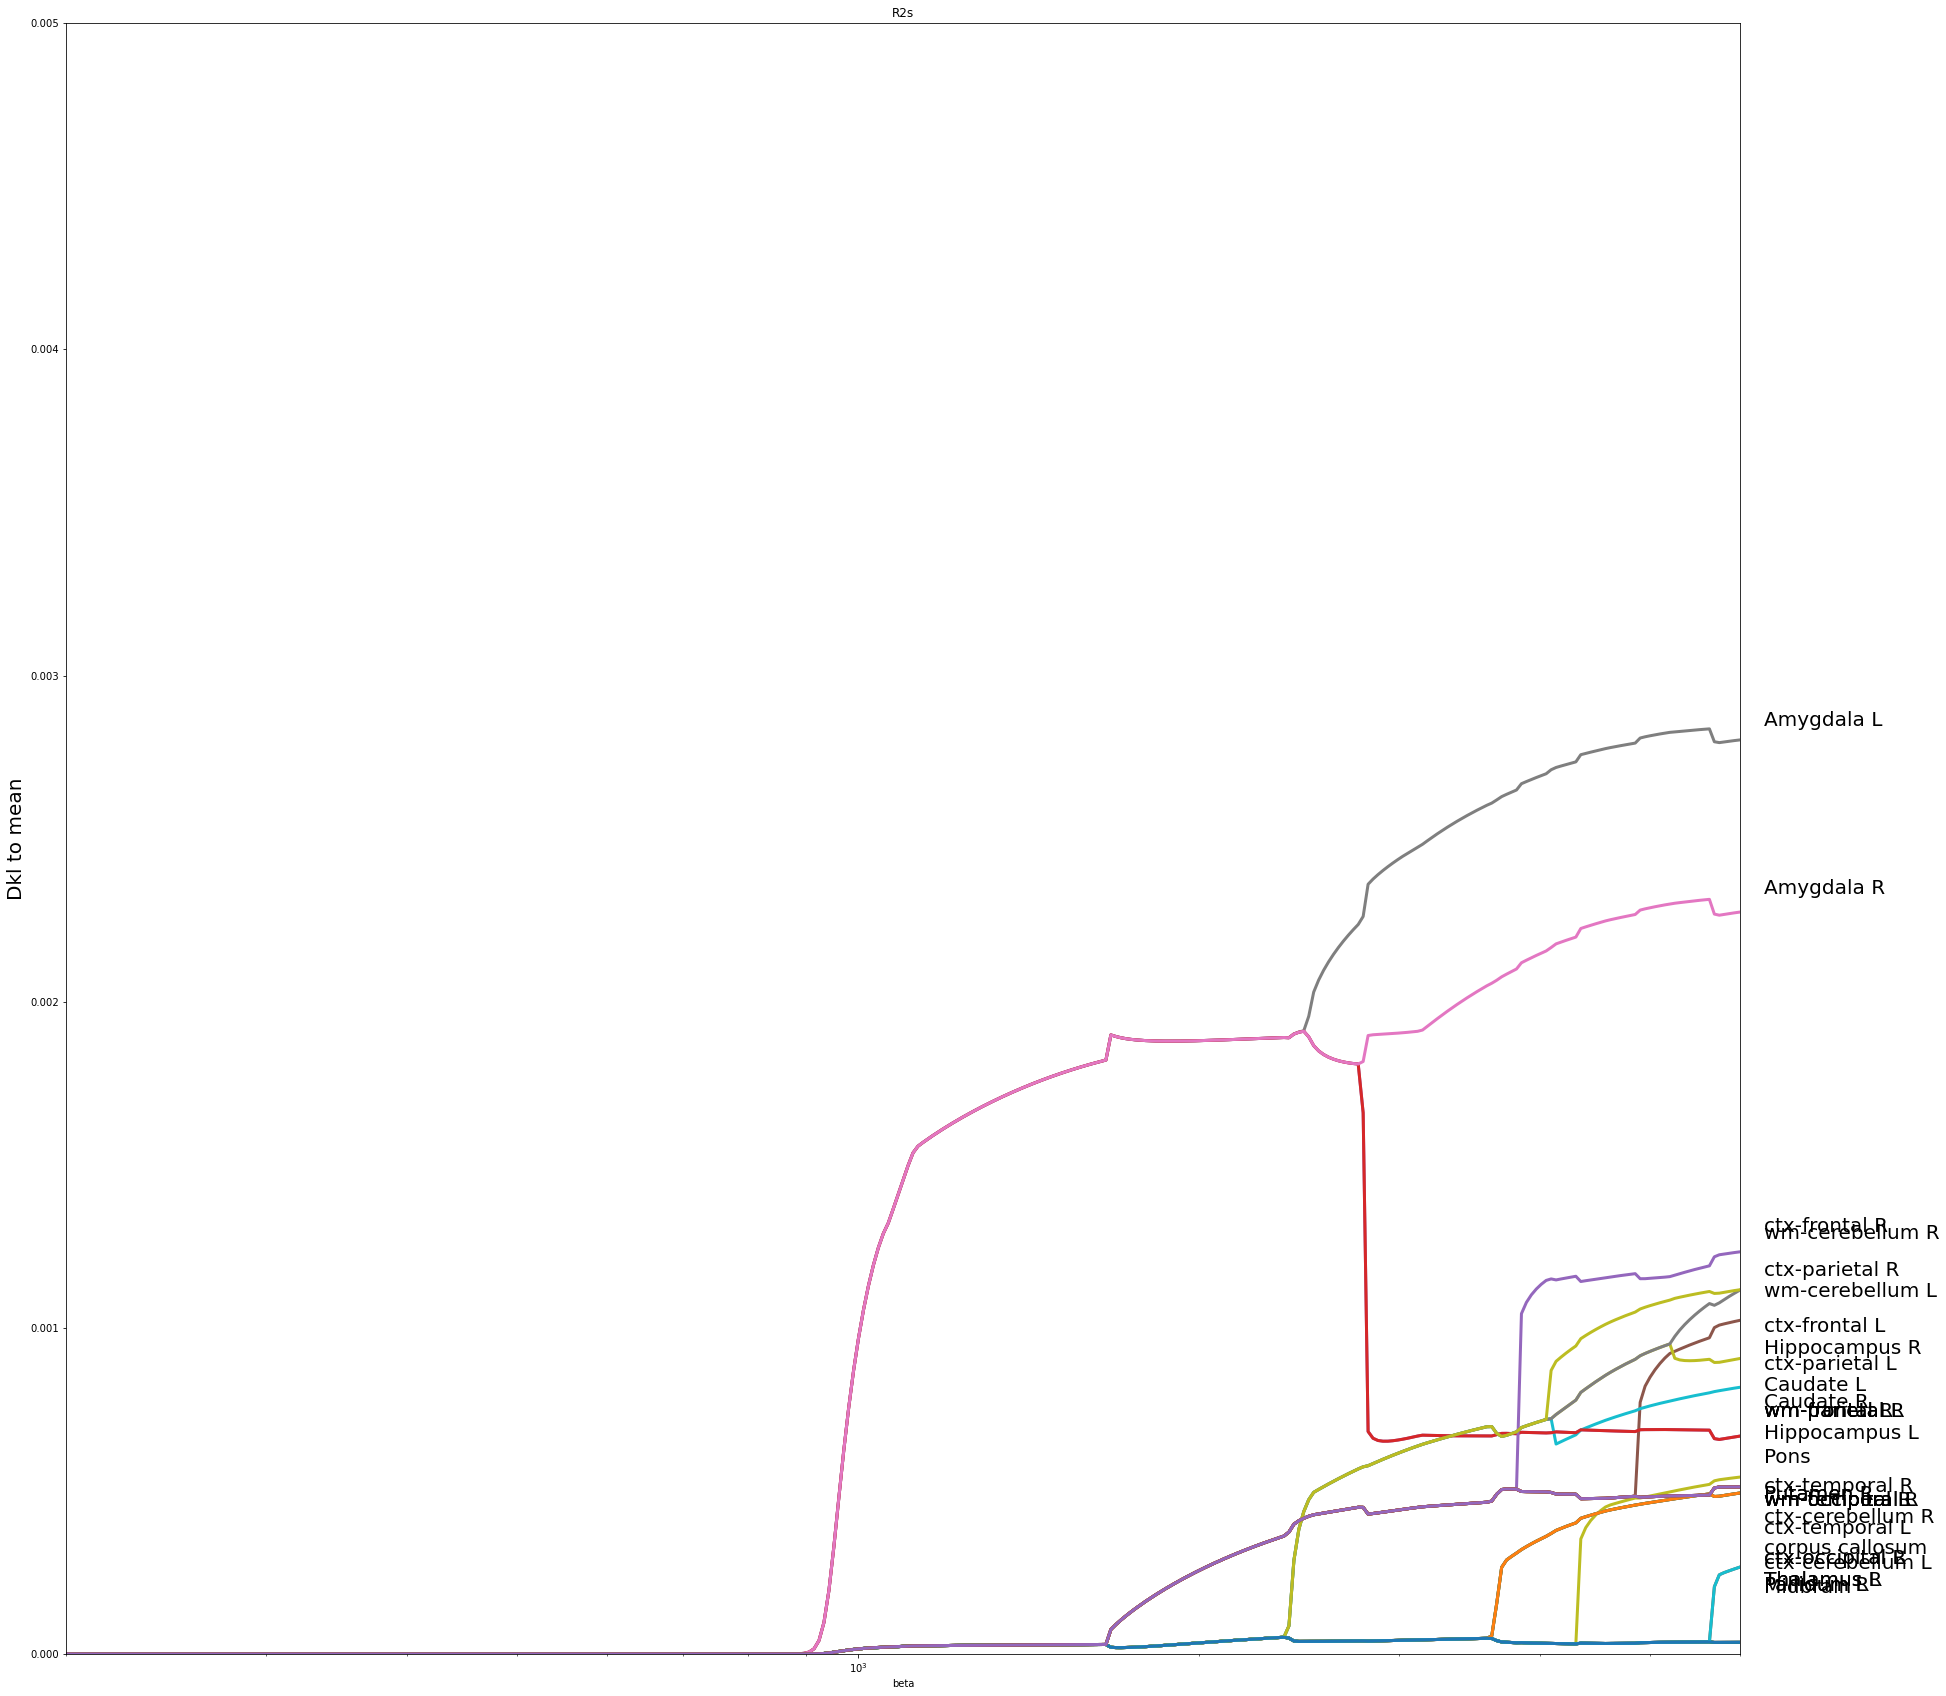

In [70]:
plot_results(ib_data)

In [60]:
def find_multi(tt,x):
    return [i for i, y in enumerate(tt) if y == x]

tt = np.array(ib_data.clusters_matrix)
num = tt.shape[1]
idx_lst = list(range(num))
cntr = num
Z = []
running_idx = 1

def clus_iter(tt,cntr,idx_lst,iter_num,Z,running_idx):
    pp = list(tt[iter_num,:])
    for x in set(pp):
        if list(pp).count(x) > 1 and x != -1:
            idxs = find_multi(pp,x)
            if len(idxs) > 2:
                print('oops', idxs)
            tt[:,idxs[0]] = -1
            print('merge ' + str(idx_lst[idxs[1]]) + ' and ' + str(idx_lst[idxs[0]]) + ' into ' + str(cntr))
            Z.append([idx_lst[idxs[1]], idx_lst[idxs[0]], iter_num, running_idx])
            idx_lst[idxs[1]] = cntr
            idx_lst[idxs[0]] = cntr
            cntr += 1
            running_idx += 1
    
    return tt,cntr,idx_lst,Z,running_idx
    
    
#print(tt.shape[0])

#for idx in range(-1,-tt.shape[0]-1,-1):
for idx in range(tt.shape[0]):
    tt,cntr,idx_lst,Z,running_idx = clus_iter(tt,cntr,idx_lst,idx,Z,running_idx)

Z = np.array(Z,dtype = 'double')
#print(tt[-16,:])
#print(tt[-20,:])
#print(idx_lst)

#print(area_names[19])
print(Z)
Z[:,2] = Z[:,2]-min(Z[:,2])

for i in range(Z.shape[0]):
    Z[i,2] = i*5
    #if Z[i,0] > 27:
    #    Z[i,0] = Z[i,0] - 1
    #if Z[i,1] > 27:
    #    Z[i,1] = Z[i,1] - 1
        
#Z = Z[:-1,:]
#print(Z)

[[25 10 15 ...  9 17 17]
 [24 10 15 ...  9 17 17]
 [24 10 15 ...  9 17 17]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
35
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
oops [12, 13, 31, 32]
merge 13 and 12 into 35
merge 21 and 2 into 36
oops [14, 15, 33, 34]
merge 15 and 14 into 37
merge 22 and 3 into 38
merge 19 and 0 into 39
oops [13, 31, 32]
merge 31 and 35 into 40
oops [15, 33, 34]
merge 33 and 37 into 41
merge 30 and 11 into 42
merge 32 and 40 into 43
merge 34 and 41 into 44
merge 20 and 1 into 45
merge 44 and 16 into 46
merge 23 and 4 into 47
merge 39 and 17 into 48
merge 42 and 6 into 49
merge 46 and 43 into 50
merge 36 and 45 into 51
merge 38 and 48 into 52
merge 49 and 52 into 53
merge 53 and 10 into 54
merge 29 and 25 into 55
merge 54 and 55 into 56
merge 27 and 8 into 57
merge 50 and 5 into 58
merge 56 and 18 into 59
merge 57 and 9 into 60
merge 28 and 60

In [55]:
ib_data.clusters_matrix

[array([25, 10, 15, 21, 14,  5, 19,  1,  8,  6, 18, 23,  9,  9, 17, 17, 20,
        24, 13, 25, 11, 15, 21,  3,  4, 16,  2,  7,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  5, 19,  1,  8,  6, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  3,  4, 16,  2,  7,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 13,  5, 19,  1,  8,  6, 18, 22,  9,  9, 17, 17, 20,
        23, 14, 24, 11, 15, 21,  3,  4, 16,  2,  7,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  4, 19,  1,  7,  5, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  8,  3, 16,  2,  6,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  4, 19,  1,  7,  5, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  8,  3, 16,  2,  6,  0, 12, 22,  9,  9, 17,
        17]),
 array([24, 10, 15, 21, 14,  4, 19,  1,  7,  5, 18, 22,  9,  9, 17, 17, 20,
        23, 13, 24, 11, 15, 21,  8,  3, 16,  2,  6,  0, 12, 22,  9,  9, 17,
        17]),
 arr

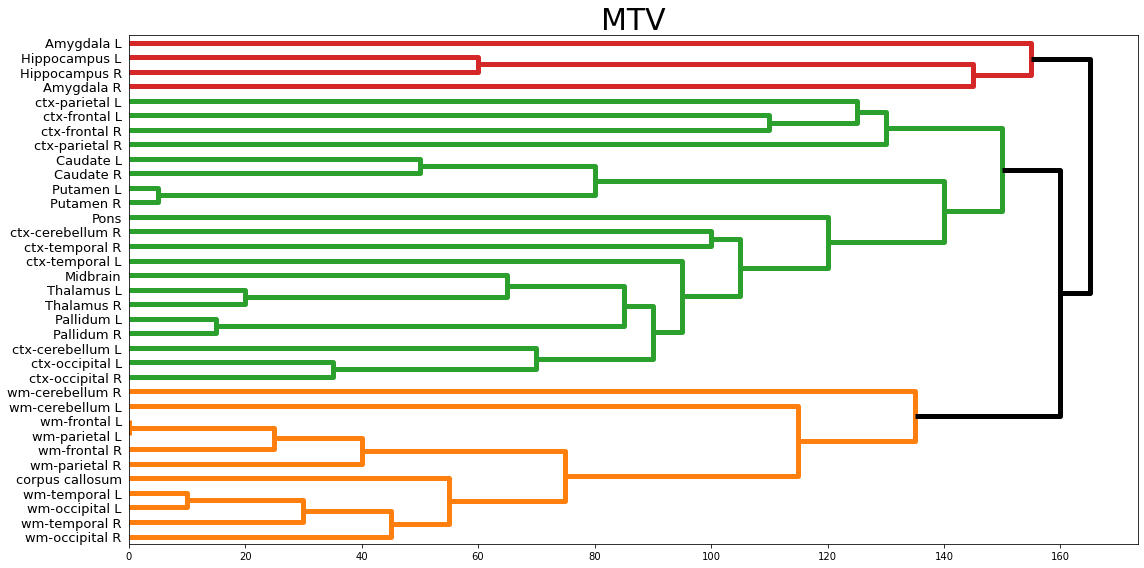

In [63]:
# Override the default linewidth.
matplotlib.rcParams['lines.linewidth'] = 5

fig, ax = plt.subplots(1,1)
ax.set_title('MTV', fontsize=30)
fig.set_size_inches(16,8)
#dn = hierarchy.dendrogram(Z,labels=area_names,leaf_rotation=-80, ax=ax)
if ib_data.analyse_by_areas:
    dn = hierarchy.dendrogram(Z,labels=ib_data.area_names, ax=ax, orientation = 'right',color_threshold = 160,above_threshold_color='k')
    #dn = hierarchy.dendrogram(Z,labels=area_names, ax=ax, color_threshold = 160,above_threshold_color='k',leaf_rotation=-80)
else:
    #dn = hierarchy.dendrogram(Z,labels=[subj_to_text(x) for x in subjects[contrast]],orientation = 'right',leaf_rotation=-80, ax=ax)
    dn = hierarchy.dendrogram(Z,labels=[subj_to_text(x) for x in ib_data.subjects[contrast]],
                              ax=ax,leaf_rotation=-80,color_threshold = 205, above_threshold_color='k')
    #dn = hierarchy.dendrogram(Z,labels=[subj_to_text(x) for x in subjects[contrast]],
    #                          ax=ax,color_threshold = 300, above_threshold_color='k',orientation = 'right')
#dn = hierarchy.dendrogram(Z,labels=area_names, ax=ax)
#dn = hierarchy.dendrogram(Z,leaf_rotation=-80, ax=ax)
#ax.tick_params(axis='x',which = 'major', labelsize=15)
ax.tick_params(axis='y',which = 'major', labelsize=13)
plt.tight_layout()

#hierarchy.set_link_color_palette(['#045a8d', '#2b8cbe', '#74a9cf', '#a6bddb'])
#hierarchy.set_link_color_palette(['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462'][::-1])
#hierarchy.set_link_color_palette(['#66c2a5','#fc8d62','#8da0cb','#e78ac3'][::-1])
#hierarchy.set_link_color_palette(['#993404','#406020','#fd8d3c','#732673'][::-1])
hierarchy.set_link_color_palette(['#993404','#64ad30','#a2142e','#7e2f8e'][::-1])
#bordo: a2142e
#orange: d95319
#yellow: eeb220


#region_color = {'other':'k','bg':'y','limbic':'b','ctx':'r','wm':'g'}
#region_color = {'other':'k','bg':'#1f78b4','limbic':'k','ctx':'#e31a1c','wm':'#33a02c'}
region_color = {'other':'#aaaaaa','bg':'#aaaaaa','limbic':'#aaaaaa','ctx':'#636363','wm':'k'}

# if analyse_areas:
#     for ticklabel in plt.gca().get_yticklabels():
#         ticklabel.set_color(region_color[region[ticklabel.get_text()]])
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False)
#     plt.xlabel('Clustering level')
# else:
#     for ticklabel in plt.gca().get_yticklabels():
#         if int(subjects[contrast][int(ticklabel.get_text())][1])>50:
#         #if int(ticklabel.get_text()[5:7])>50:
#             ticklabel.set_color('#636363')
#         else:
#             ticklabel.set_color('k')
#             ticklabel.set_fontweight('bold')

    
#hierarchy.set_link_color_palette(None)
#print([subj_to_text(x) for x in subjects[contrast]])
#plt.savefig('C:\\Users\\Yoav\\Desktop\\ELSC\\Aviv\\Tali\\IB\\MTV_for_grant4.png')
#plt.savefig('C:\\Users\\Yoav\\Desktop\\ELSC\\Aviv\\Tali\\grant\\MTV_areas4.png')
# plt.savefig('D:\\ELSC\\Aviv\\Tali\\grant\\new_MTV_6.png')

[6 5 5 6 3 4 6 0 2 2 6 6 4 4 4 4 4 6 6 6 5 5 6 3 4 6 1 2 2 6 6 4 4 4 4]
(45, 35)
ShapiroResult(statistic=0.9309542179107666, pvalue=2.3247735499095084e-26)
0 Thalamus L
3 Pallidum L
6 ctx-cerebellum L
10 ctx-temporal L
11 ctx-occipital L
17 Midbrain
18 Pons
19 Thalamus R
22 Pallidum R
25 ctx-cerebellum R
29 ctx-temporal R
30 ctx-occipital R


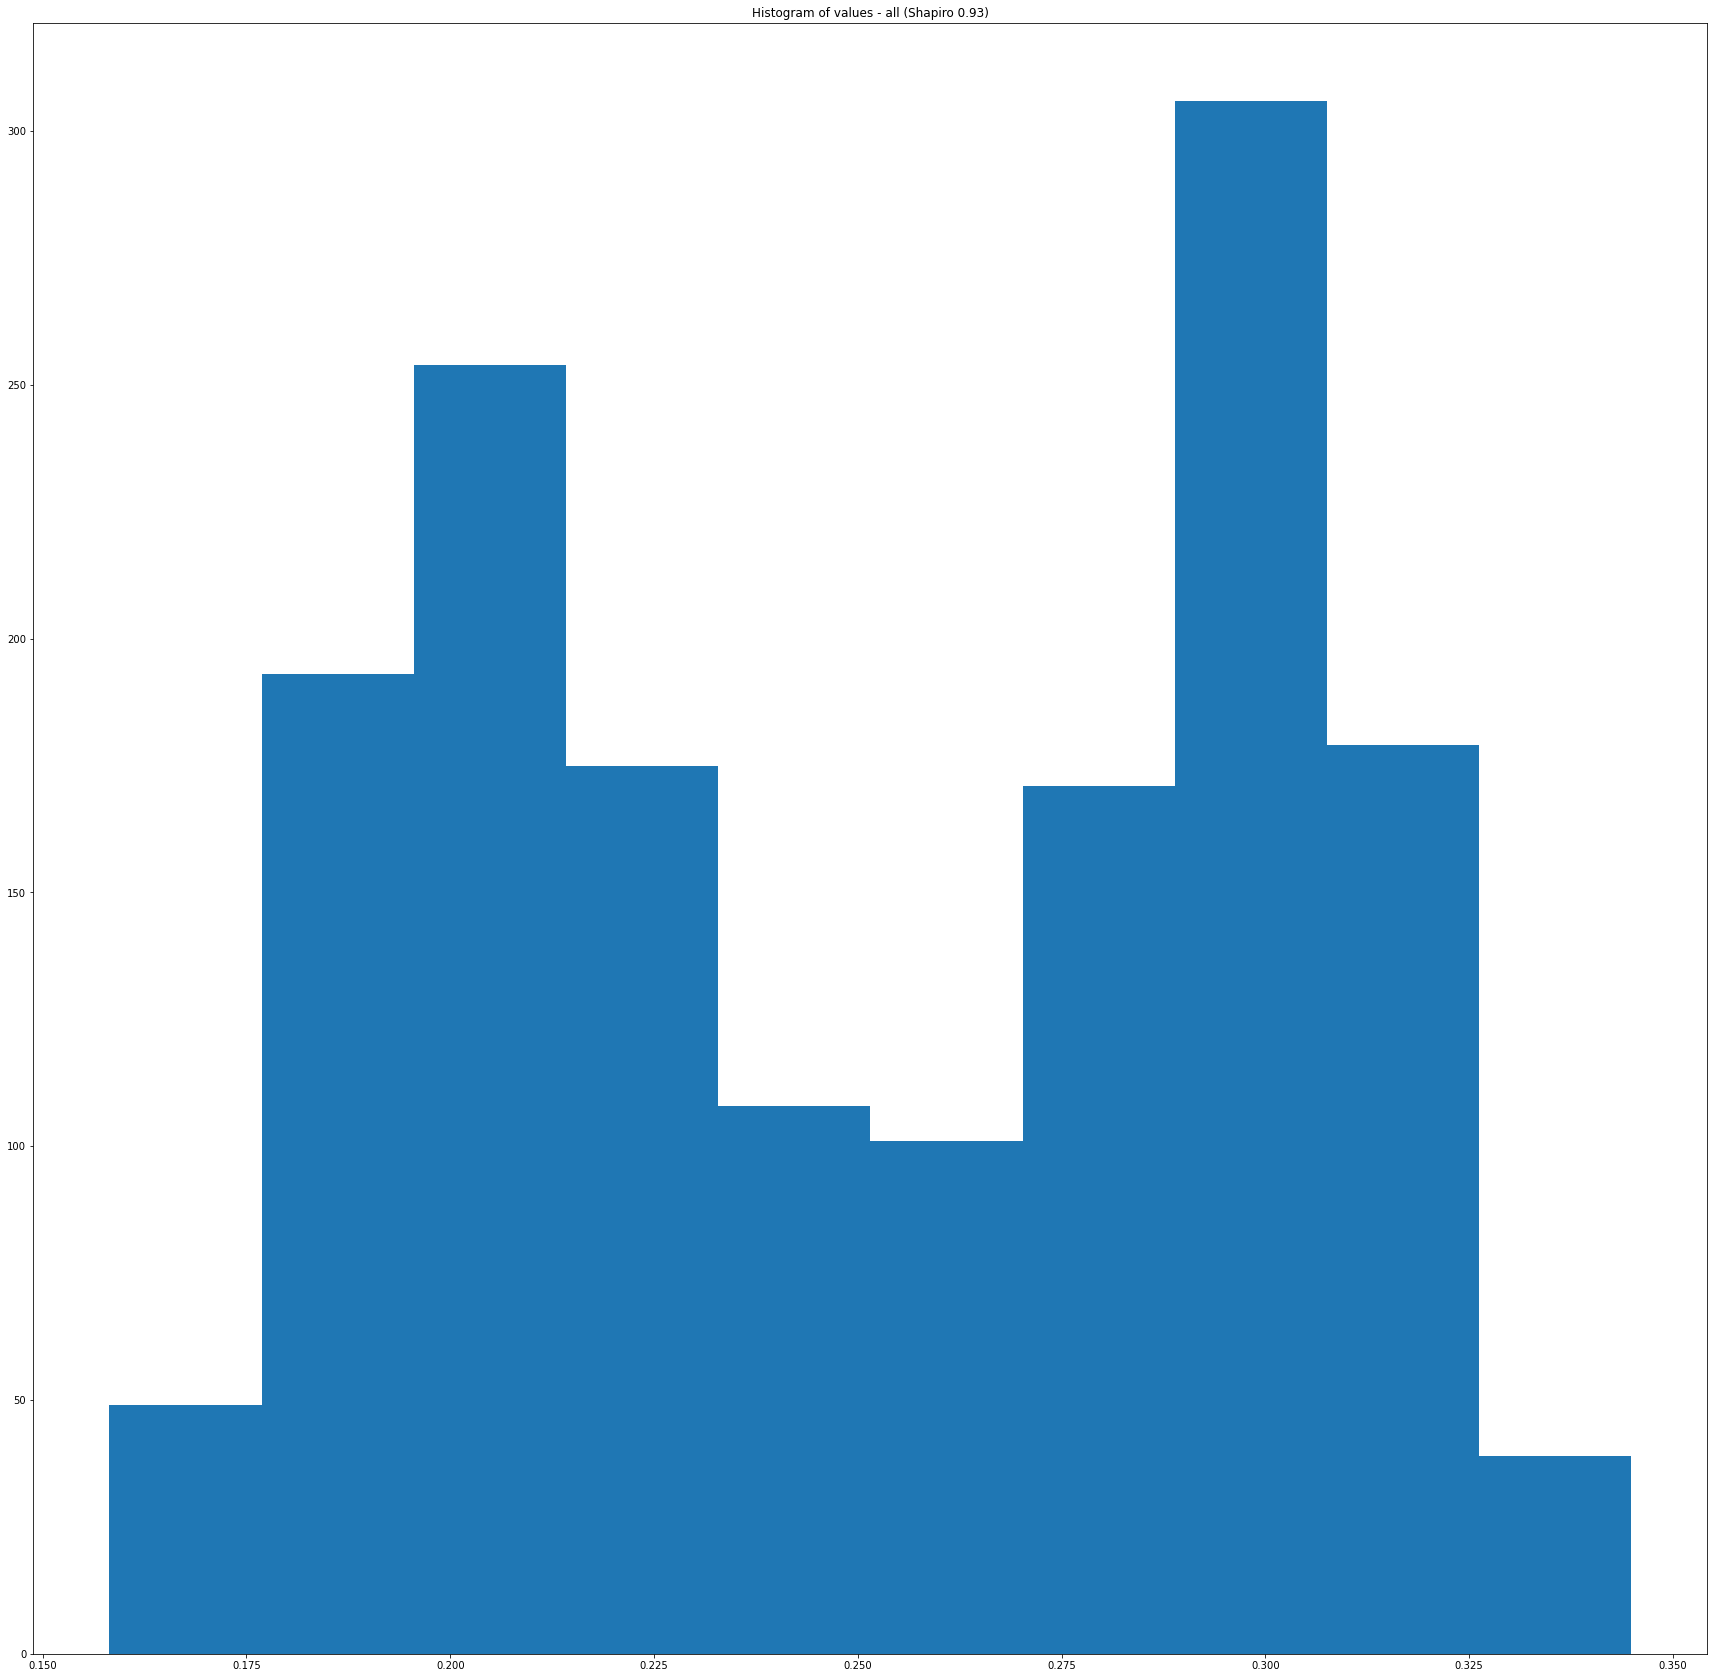

In [68]:
# I need to check normality of p(y|xhat), where xhat are the areas?
from scipy import stats
#shapiro_test = stats.shapiro(x)
#shapiro_test
# 45 subjects
# p_y_x_hat.shape
clus_areas = ib_data.clus.copy()
clusters_matrix_areas = ib_data.clusters_matrix.copy()
print(clusters_matrix_areas[100])
print(ib_data.input_matrix.shape)
print(stats.shapiro((ib_data.input_matrix[:,clusters_matrix_areas[100]<=6])))
# stats.shapiro(input_matrix[1,clusters_matrix_subjects[400]==3])
plt.hist((np.matrix.flatten(ib_data.input_matrix[:,clusters_matrix_areas[100]<=6])))
plt.title('Histogram of values - all (Shapiro 0.93)')
for i in range(len(clusters_matrix_areas[100])):
    if clusters_matrix_areas[100][i] == 6:
        print(i, ib_data.area_names[i])
# list(clusters_matrix_areas[500]==0)]
# plt.savefig('D:\\ELSC\\Aviv\\Tali\\right_norm\\x\\all.png')